# NONRAD Tutorial

This notebook serves as a tutorial for how to use the NONRAD code to compute the nonradiative capture coefficient for a given defect. In this tutorial, we will examine the capture of a hole by the negatively charge C substiution on the N site in wurtzite GaN.


**Recommendation**: For every function provided by NONRAD, read the docstring to understand how the function behaves. This can be done using `function?` in a notebook or `print(function.__doc__)`.

## 0. First-Principles Defect Calculation

Before we begin using the code provided by NONRAD, we must perform a first-principles calculation to obtain the equilibrium structures and thermodynamic level for our defect. This results in a formation energy plot such as the following.

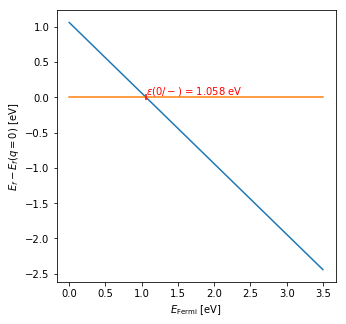

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

Efermi = np.linspace(0., 3.5, 10)
fig, ax = plt.subplots(figsize=(5, 5))
ax.plot(Efermi, - Efermi + 1.058)
ax.plot(Efermi, np.zeros(10))
ax.scatter(1.058, 0., color='r', marker='|', zorder=10)
ax.text(1.058, 0., '$\epsilon (0/-)$ = 1.058 eV', color='r', va='bottom')
ax.set_xlabel(r'$E_{\rm{Fermi}}$ [eV]')
ax.set_ylabel(r'$E_f - E_f(q=0)$ [eV]')
plt.show()

The formation energy plot tells us the most stable charge state as a function of the Fermi level. The blue line corresponds to the C substitution being in the negative charge state, and the orange line corresponds to the neutral charge state. The thermodynamic transition level is the crossing between these two lines and for this defect, we find a value of 1.058 eV. This will be one input parameter to the calculation of the nonradiative capture coefficient, `dE`. Let's save this value for later:

In [2]:
dE = 1.058 # eV

## 1. Compute Configuration Coordinate Diagram

#### Preparing the CCD Calculations
We now are ready to prepare our configuration coordinate diagram. This is facilitated by the utilities provided by the NONRAD code. One needs to interpolate between the ground (neutral) and excited (negative) configurations. The following code can be used to prepare the input files for the ab initio calculation (example for `VASP` is shown below).

In [3]:
import os
from pathlib import Path
from shutil import copyfile
from pymatgen import Structure
from nonrad.utils import get_cc_structures

# equilibrium structures from your first-principles calculation
ground_files = Path('/path/to/C0/relax/')
ground_struct = Structure.from_file(str(ground_files / 'CONTCAR'))
excited_files = Path('/path/to/C-/relax/')
excited_struct = Structure.from_file(str(excited_files / 'CONTCAR'))

# output directory that will contain the input files for the CC diagram
cc_dir = Path('/path/to/cc_dir')
os.mkdir(str(cc_dir))
os.mkdir(str(cc_dir / 'ground'))
os.mkdir(str(cc_dir / 'excited'))

# displacements as a percentage, this will generate the displacements
# -50%, -37.5%, -25%, -12.5%, 0%, 12.5%, 25%, 37.5%, 50%
displacements = np.linspace(-0.5, 0.5, 9)

# note: the returned structures won't include the 0% displacement, this is intended
# it can be included by specifying remove_zero=False
ground, excited = get_cc_structures(ground_struct, excited_struct, displacements)

for i, struct in enumerate(ground):
    working_dir = cc_dir / 'ground' / str(i)
    os.mkdir(str(working_dir))
    
    # write structure and copy necessary input files
    struct.to(filename=str(working_dir / 'POSCAR'), fmt='poscar')
    for f in ['KPOINTS', 'POTCAR', 'INCAR', 'submit.job']:
        copyfile(str(ground_files / f), str(working_dir / f))
        
for i, struct in enumerate(excited):
    working_dir = cc_dir / 'excited' / str(i)
    os.mkdir(str(working_dir))
    
    # write structure and copy necessary input files
    struct.to(filename=str(working_dir / 'POSCAR'), fmt='poscar')
    for f in ['KPOINTS', 'POTCAR', 'INCAR', 'submit.job']:
        copyfile(str(ground_files / f), str(working_dir / f))

Before submitting the calculations prepared above, the INCAR files should be modified to remove the `IBRION` flag (no relaxation should be performed).

One of the nice features provided by the NONRAD code is the `get_Q_from_struct` function, which can determine the Q value from the interpolated structure and the endpoints. Therefore, we don't need any fancy naming schemes or tricks to prepare our potential energy surfaces.

#### Extracting the Potential Energy Surface and Relevant Parameters

Once the calculations have completed, we can extract the potential energy surface using the functions provided by NONRAD. The below code extracts the potential energy surfaces and plots them. Furthermore, it will extract the dQ value and the phonon frequencies of the potential energy surfaces. These are 3 input parameters for the calculation of the nonradiative capture coefficient.

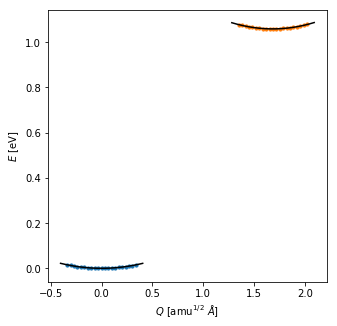

In [4]:
from glob import glob
from nonrad.utils import get_dQ, get_PES_from_vaspruns, get_omega_from_PES

# calculate dQ
dQ = get_dQ(ground_struct, excited_struct) # amu^{1/2} Angstrom

# this prepares a list of all vasprun.xml's from the CCD calculations
ground_vaspruns = glob(str(cc_dir / 'ground' / '*' / 'vasprun.xml'))
excited_vaspruns = glob(str(cc_dir / 'excited' / '*' / 'vasprun.xml'))

# remember that the 0% displacement was removed before? we need to add that back in here
ground_vaspruns = ground_vaspruns + [str(ground_files / 'vasprun.xml')]
excited_vaspruns = excited_vaspruns + [str(excited_files / 'vasprun.xml')]

# extract the potential energy surface
Q_ground, E_ground = get_PES_from_vaspruns(ground_struct, excited_struct, ground_vaspruns)
Q_excited, E_excited = get_PES_from_vaspruns(ground_struct, excited_struct, excited_vaspruns)

# the energy surfaces are referenced to the minimums, so we need to add dE (defined before) to E_excited
E_excited = dE + E_excited

fig, ax = plt.subplots(figsize=(5, 5))
ax.scatter(Q_ground, E_ground, s=10)
ax.scatter(Q_excited, E_excited, s=10)

# by passing in the axis object, it also plots the fitted curve
ground_omega = get_omega_from_PES(Q_ground, E_ground, ax=ax)
excited_omega = get_omega_from_PES(Q_excited, E_excited, ax=ax)

ax.set_xlabel('$Q$ [amu$^{1/2}$ $\AA$]')
ax.set_ylabel('$E$ [eV]')
plt.show()

The resulting input parameters that we have extracted for our calculation of the nonradiative recombination coefficient are below.

In [5]:
print(f'dQ = {dQ:7.05f} amu^(1/2) Angstrom, ground_omega = {ground_omega:7.05f} eV, excited_omega = {excited_omega:7.05f} eV')

dQ = 1.68588 amu^(1/2) Angstrom, ground_omega = 0.03358 eV, excited_omega = 0.03754 eV


## 2. Calculate the Electron-Phonon Coupling Matrix Element

Before computing the el-ph matrix elements, it is highly suggested that you re-read the [original methodology paper](http://dx.doi.org/10.1103/PhysRevB.90.075202) and the [code implementation paper]() to make sure you understand the details.

For the C substitution we are considering, when the geometry of the defect ($\{Q_0\}$) corresponds to the neutral charge state, a well-defined Kohn-Sham state associated with the defect is clear and sits in the gap. Therefore, we compute the el-ph matrix elements by expanding around this configuration.

For the `VASP` calculations, the `WAVECAR` file for the $Q = 0$ geometry is copied to `WAVECAR.qqq` and `LWSWQ = True` is set in the `INCAR` file. The resulting `WSWQ` files can be parsed using functions provided by NONRAD.

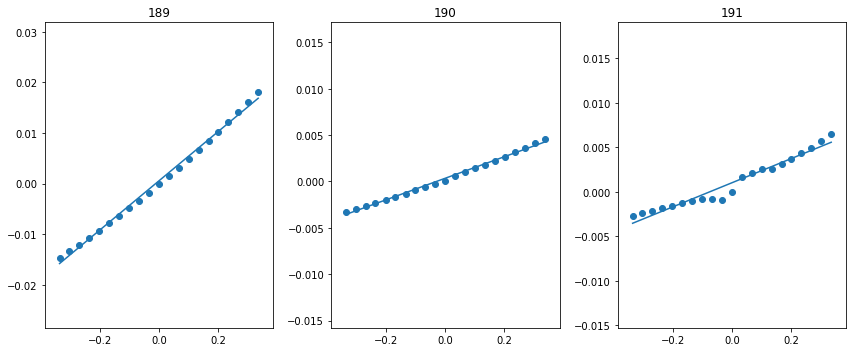

In [6]:
from nonrad.utils import get_Q_from_struct, get_Wif_from_WSWQ

# this generates a list of tuples where the first value of the tuple is a Q value
# and the second is the path to the WSWQ file that corresponds to that tuple
WSWQs = []
for d in glob(str(cc_dir / 'ground' / '*')):
    pd = Path(d)
    Q = get_Q_from_struct(ground_struct, excited_struct, str(pd / 'CONTCAR'))
    path_wswq = str(pd / 'WSWQ')
    WSWQs.append((Q, path_wswq))

# by passing a figure object, we can inspect the resulting plots
fig = plt.figure(figsize=(12, 5))
Wifs = get_Wif_from_WSWQ(WSWQs, str(ground_files / 'vasprun.xml'), 192, [189, 190, 191], spin=1, fig=fig)
plt.tight_layout()
plt.show()

We pass as input, the indices of the 3 valence bands. What we find is that the valence band that is pushed down in energy has the greatest el-ph matrix element. This makes sense because it is pushed down by the interaction with the defect state.

**NOTE**: We highly recommend passing a figure object to view the resulting plot. This ensures that the value obtained is reasonable.

The resulting values of the matrix elements are shown below. They are in units of eV amu$^{-1/2}$ $\unicode{xC5}^{-1}$. This can be directly input into the nonradiative capture calculation.

In [7]:
print(Wifs)
Wif = Wifs[0][1]

[(189, 0.08081487879834824), (190, 0.020450559002109615), (191, 0.0259145184003146)]


#### Alternative Method (Note: not publication quality)

Another method for obtaining the Wif value would be to use the pseudo-wavefunctions from the `WAVECAR` files. This will neglect the core information. For some defect systems, this is not a bad approximation. The quality of the result can generally be judged by the overlap at $Q = 0$. If the overlap is almost zero (maybe < 0.05), then the result should be reasonably reliable. Please only use this to get a rough idea, the above method is preferred. This is facilitated by the `get_Wif_from_wavecars` function.

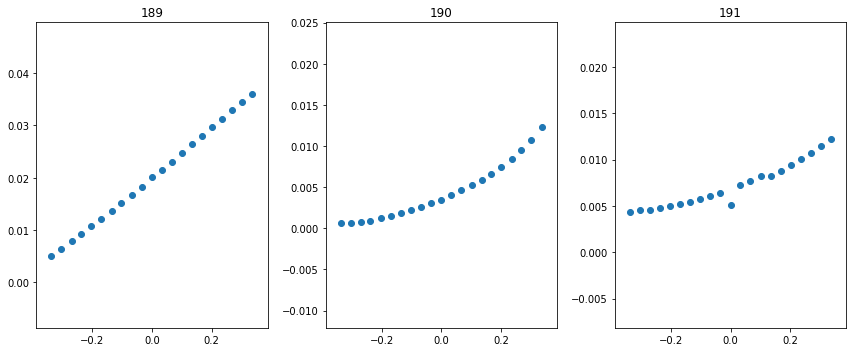

In [8]:
from nonrad.utils import get_Wif_from_wavecars

# this generates a list of tuples where the first value of the tuple is a Q value
# and the second is the path to the WAVECAR file that corresponds to that tuple
wavecars = []
for d in glob(str(cc_dir / 'ground' / '*')):
    pd = Path(d)
    Q = get_Q_from_struct(ground_struct, excited_struct, str(pd / 'CONTCAR'))
    path_wavecar = str(pd / 'WAVECAR')
    wavecars.append((Q, path_wavecar))
    
# by passing a figure object, we can inspect the resulting plots
fig = plt.figure(figsize=(12, 5))
Wifs = get_Wif_from_wavecars(wavecars, str(ground_files / 'WAVECAR'), 192, [189, 190, 191], spin=1, fig=fig)
plt.tight_layout()
plt.show()

As we can see, the results are reasonably close because the Q = 0 value is somewhat low.

In [9]:
print(Wifs)

[(189, 0.08609599795923484), (190, 0.030574033957316595), (191, 0.019013362685731866)]


## 3. Compute Scaling Parameters

When calculating the capture coefficient, we need to take into account two effects. First is the coulombic interaction between the carrier and defect. This occurs when the carrier is captured into a defect with a non-zero charge state. Second, there is the effect on the el-ph matrix element as a result of using a finite-size charged supercell. This leads to a suppression or enhancement of the charge density near the defect and would not occur in an infinitely large supercell.

#### Sommerfeld Parameter

The Sommerfeld parameter captures the long-range coulombic interaction that can affect the capture rates. The interaction can be attractive or repulsive and may enhance or suppress the resulting rate.

For our system, we have the C substitution capturing a hole in the negative charge state, so there will be a long-range coulombic attraction that enhances the capture rates. One input parameter for the Sommerfeld parameter is the Z value. We define it as $Z = Q / q$, where $Q$ is the charge of the defect and $q$ is the charge of the carrier. For a negatively charge defect ($Q = -1$) interacting with a hole ($q = +1$), we have $Z = -1$. $Z < 0$ is an attractive center, while $Z > 0$ is a repulsive center.

Below, we calculate the scaling coefficient. Note, we use the hole effective mass (because we are capturing a hole) and the static dielectric constant.

In [10]:
from nonrad.scaling import sommerfeld_parameter

Z = -1
m_eff = 0.18 # hole effective mass of GaN
eps_0 = 8.9  # static dielectric constant of GaN

# We can compute the Sommerfeld parameter at a single temperature
print(f'Sommerfeld Parameter @ 300K: {sommerfeld_parameter(300, Z, m_eff, eps_0):7.05f}')

# or we can compute it at a range of temperatures
T = np.linspace(25, 800, 1000)
f = sommerfeld_parameter(T, Z, m_eff, eps_0)

Sommerfeld Parameter @ 300K: 7.75344


#### Charged Supercell Effects

**First and foremost**: if you can compute the el-ph matrix element in the neutral charge state, you *should* do this. This avoids the extra scaling factor completely. This is exactly the case for the C substitution that we are studying here. The el-ph matrix elements are calculated in the neutral charge state, so *no additional scaling is needed*.

For illustration purposes, we shall examine how we would compute this scaling coefficient *if it were necessary* by studying the wavefunctions in the negative charge state. Here, we have a spurious interaction that suppresses or enhances the charge density of the bulk wavefunctions near the charged defect. The scaling coefficient is calculated by comparing the radial distribution of the charge density to a purely homogenous distribution. The function `charged_supercell_scaling` computes the scaling factor.

Below is an example of the interaction with the valence band:

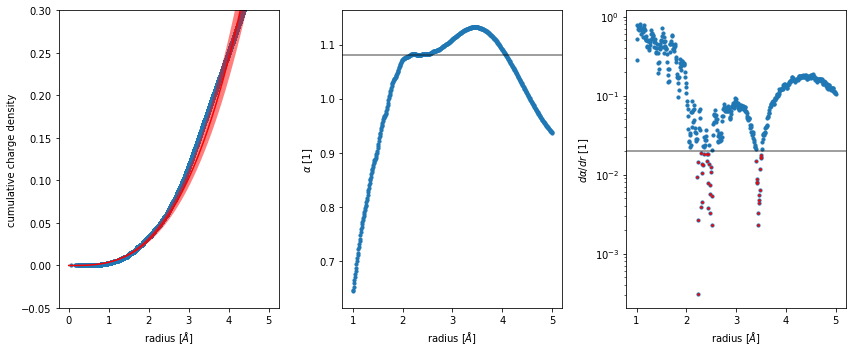

scaling = 0.8573388203017832


In [11]:
from nonrad.scaling import charged_supercell_scaling

wavecar_path = str(excited_files / 'WAVECAR')

fig = plt.figure(figsize=(12, 5))
factor = charged_supercell_scaling(wavecar_path, 192, 189, fig=fig)
plt.tight_layout()
plt.show()

print('scaling =', 1 / factor**2)

The left-most plot is of the cumulative charge density (blue) against a homogenous distribution (red). The scaling parameter that brings the two into agreement is shown in the second plot. A plateau is found around ~2-3 $\unicode{xC5}$. This is the value that we use for the scaling. If we had calculated the el-ph matrix elements in the negative charge state, we would scale the capture coefficient by 1 over this value squared (printed above). For completeness, the right-most plot is the derivative of the scaling coefficient, which provides an algorithmic way to find the plateau.

Below we show the process for the interaction with the conduction band.

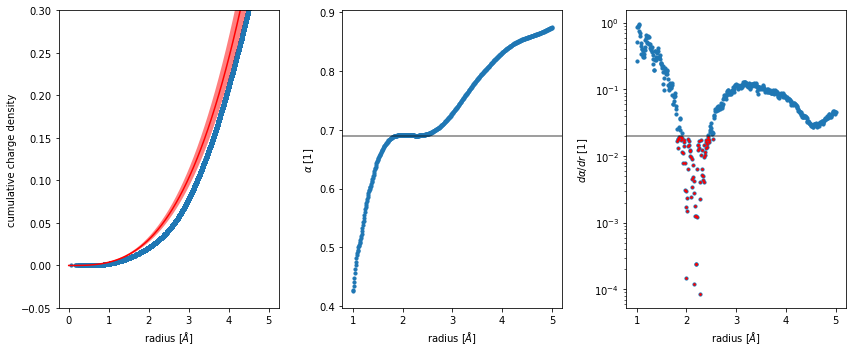

scaling = 2.100399075824407


In [12]:
fig = plt.figure(figsize=(12, 5))
factor = charged_supercell_scaling(wavecar_path, 192, 193, fig=fig)
plt.tight_layout()
plt.show()

print('scaling =', 1 / factor**2)

Here we see that the distribution is suppressed near the defect.

## 4. Compute the Nonradiative Capture Coefficient

We are now ready to compute the capture coefficient. This is the easiest step compared to all that we have done above. We simply need to plug in the values that we extracted. The only input parameter we need to think about is the configurational degeneracy. For a C substitution, there are 4 identical defect configurations (one along each bond) that the hole can be captured into.

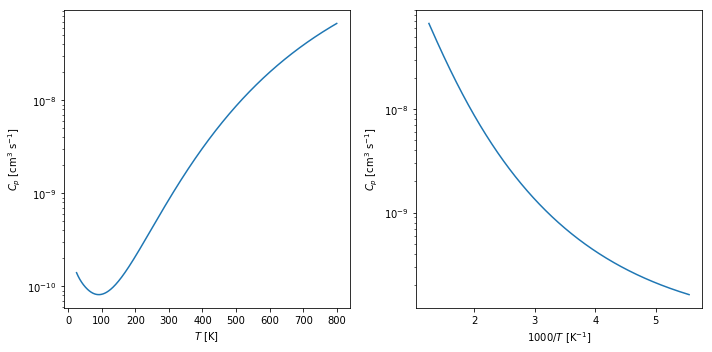

In [13]:
from nonrad import get_C

g = 4 # configurational degeneracy
volume = ground_struct.volume # Angstrom^3

# we pass in T, which is a numpy array
# we will get the capture coefficient at each of these temperatures
Ctilde = get_C(dQ, dE, excited_omega, ground_omega, Wif, volume, g=g, T=T)

# apply Sommerfeld parameter, evaluated at the same temperatures
C = f * Ctilde

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].semilogy(T, C)
ax[0].set_xlabel('$T$ [K]')
ax[0].set_ylabel('$C_p$ [cm$^{3}$ s$^{-1}$]')
ax[1].semilogy(1000 / T[200:], C[200:])
ax[1].set_xlabel('$1000 / T$ [K$^{-1}$]')
ax[1].set_ylabel('$C_p$ [cm$^{3}$ s$^{-1}$]')
plt.tight_layout()
plt.show()

We may also want to calculate the capture cross section, $\sigma = C / \langle v \rangle$. We can do this using the `thermal_velocity` function.

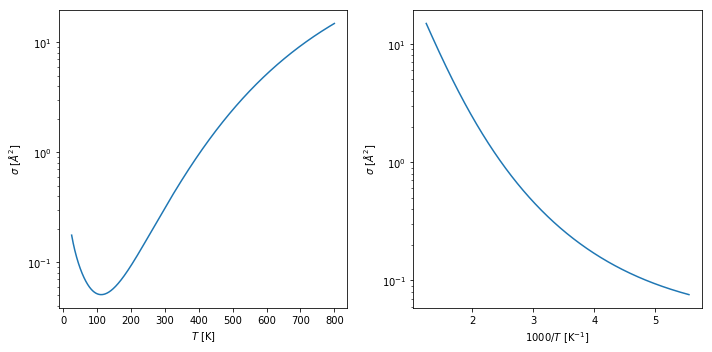

In [14]:
from nonrad.scaling import thermal_velocity

sigma = C / thermal_velocity(T, m_eff) # cm^2
sigma *= (1e8)**2 # (cm to Angstrom)^2

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].semilogy(T, sigma)
ax[0].set_xlabel('$T$ [K]')
ax[0].set_ylabel('$\sigma$ [$\AA^{2}$]')
ax[1].semilogy(1000 / T[200:], sigma[200:])
ax[1].set_xlabel('$1000 / T$ [K$^{-1}$]')
ax[1].set_ylabel('$\sigma$ [$\AA^{2}$]')
plt.tight_layout()
plt.show()